In [1]:
!pip install google-play-scraper pandas matplotlib seaborn wordcloud Sastrawi nltk scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 6.4 MB/s eta 0:00:00


Library

In [12]:
from google_play_scraper import Sort, reviews
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer

Scrapping

In [ ]:

# Daftar App ID
apps_config = [
    {'name': 'Livin Mandiri', 'id': 'id.co.bankmandiri.livin'},
    {'name': 'BCA Mobile', 'id': 'com.bca'},
    {'name': 'myBCA', 'id': 'id.co.bca.mybca'},
    {'name': 'BNI Mobile', 'id': 'src.com.bni'},
    {'name': 'Wondr BNI', 'id': 'id.co.bni.wondr'},
    {'name': 'BRImo', 'id': 'id.co.bri.brimo'}
]

def scrape_app(app_id, app_name, count=5000):
    print(f"Sedang scraping {app_name}...")
    result, _ = reviews(
        app_id,
        lang='id',
        country='id',
        sort=Sort.NEWEST,
        count=count
    )
    df = pd.DataFrame(result)
    df['app_name'] = app_name
    return df

# Melakukan scraping untuk setiap aplikasi
dfs = {}
for app in apps_config:
    dfs[app['name']] = scrape_app(app['id'], app['name'])

print("Scraping selesai.")
print(dfs.keys())

Sedang scraping Livin Mandiri...
Sedang scraping BCA Mobile...
Sedang scraping myBCA...
Sedang scraping BNI Mobile...
Sedang scraping Wondr BNI...
Sedang scraping BRImo...
Scraping selesai.
dict_keys(['Livin Mandiri', 'BCA Mobile', 'myBCA', 'BNI Mobile', 'Wondr BNI', 'BRImo'])


/tmp/ipython-input-1789722821.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=word_counts, x='app_name', y='word_count_before', palette='Blues_d')


        app_name  word_count_before  word_count_after
0     BCA Mobile              70766             41012
1     BNI Mobile              62181             31681
2          BRImo              42156             24412
3  Livin Mandiri              59177             33531
4      Wondr BNI              42042             25233
5          myBCA              63866             36641


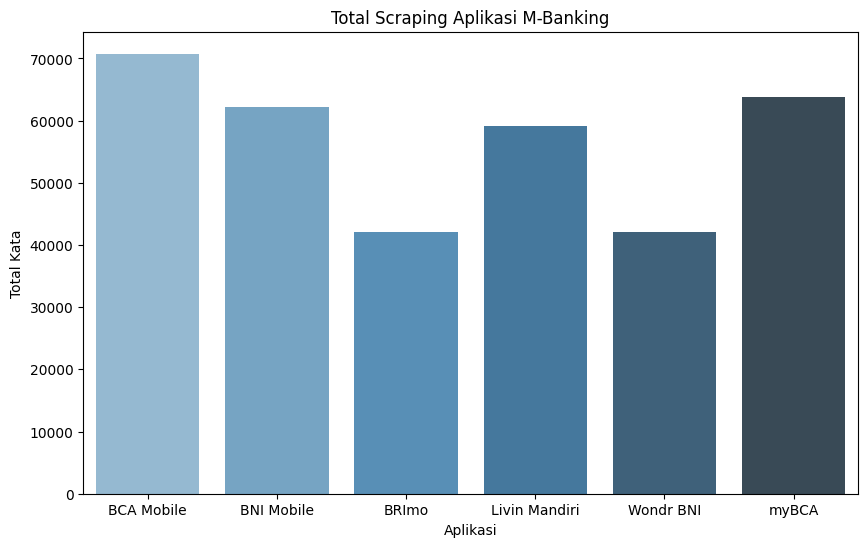

In [ ]:
# Load datasets
files = {
    'Livin Mandiri': 'ulasan_livin.csv',
    'BCA Mobile': 'ulasan_bca.csv',
    'myBCA': 'ulasan_mybca.csv',
    'BNI Mobile': 'ulasan_bnimobile.csv',
    'Wondr BNI': 'ulasan_bniwondr.csv',
    'BRImo': 'ulasan_brimo.csv'
}

dfs = []
for app_name, file_path in files.items():
    try:
        df = pd.read_csv(file_path)
        df['app_name'] = app_name
        dfs.append(df)
    except Exception as e:
        print(f"Error loading {app_name}: {e}")

df_all = pd.concat(dfs, ignore_index=True)

# Preprocessing logic
stopwords_list = set([
    'yang', 'untuk', 'pada', 'ke', 'para', 'namun', 'menurut', 'antara', 'dia', 'dua', 'ia', 'seperti', 'jika', 'sehingga', 'kembali', 'dan', 'tidak', 'ini', 'karena', 'kepada', 'oleh', 'saat', 'harus', 'sementara', 'setelah', 'belum', 'kami', 'sekitar', 'bagi', 'serta', 'di', 'dari', 'telah', 'sebagai', 'masih', 'hal', 'ketika', 'adalah', 'itu', 'dalam', 'bisa', 'bahwa', 'atau', 'hanya', 'kita', 'dengan', 'akan', 'juga', 'ada', 'mereka', 'sudah', 'saya', 'kamu', 'aku', 'anda', 'dia', 'mereka', 'kita', 'kalian', 'beliau', 'ini', 'itu', 'sini', 'situ', 'sana', 'demikian', 'begitu', 'begini', 'apa', 'siapa', 'mengapa', 'kenapa', 'dimana', 'kapan', 'bagaimana', 'berapa', 'mohon', 'tolong', 'terima', 'kasih', 'bank', 'aplikasi', 'nya', 'saja', 'lagi', 'tapi', 'kok', 'banget', 'bgt', 'gak', 'ga', 'nggak', 'udah', 'dah', 'kalo', 'kalau', 'biar', 'bikin', 'buat', 'bilang', 'dong', 'sih', 'deh', 'kan', 'lah', 'pun', 'mah'
])

norm_dict = {
    'sy': 'saya', 'aku': 'saya', 'gw': 'saya', 'gua': 'saya',
    'tdk': 'tidak', 'tak': 'tidak', 'ga': 'tidak', 'gak': 'tidak', 'nggak': 'tidak',
    'bgt': 'banget', 'bangett': 'banget', 'dlm': 'dalam', 'jgn': 'jangan', 'tp': 'tapi',
    'krn': 'karena', 'karna': 'karena', 'sdh': 'sudah', 'udah': 'sudah', 'dgn': 'dengan',
    'klo': 'kalau', 'kalo': 'kalau', 'trs': 'terus', 'msh': 'masih', 'tlg': 'tolong',
    'bka': 'buka', 'eror': 'error', 'ngelag': 'lag', 'lemot': 'lambat', 'lelet': 'lambat',
    'gabisa': 'tidak bisa', 'bs': 'bisa', 'blm': 'belum', 'jdi': 'jadi', 'smua': 'semua',
    'skrg': 'sekarang', 'brimo': '', 'livin': '', 'bca': '', 'bni': '', 'wondr': '', 'mybca': '', 'mobile': '', 'banking': ''
}

def clean_text_count(text):
    if not isinstance(text, str): return ""
    text = text.encode('ascii', 'ignore').decode('ascii')
    text = text.lower() 
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation)) 
    text = re.sub(r'(.)\1{2,}', r'\1', text) 

    words = text.split()
    final_words = []
    for word in words:
        if word in norm_dict:
            word = norm_dict[word]
            for sub in word.split():
                if len(sub) > 3 and sub not in stopwords_list:
                    final_words.append(sub)
            continue

        if len(word) <= 3: continue
        if word in stopwords_list: continue
        final_words.append(word)

    return ' '.join(final_words)

# Calculate counts
df_all['word_count_before'] = df_all['content'].astype(str).apply(lambda x: len(x.split()))
df_all['clean_content'] = df_all['content'].apply(clean_text_count)
df_all['word_count_after'] = df_all['clean_content'].apply(lambda x: len(x.split()))

# Aggregation for visualization
word_counts = df_all.groupby('app_name')[['word_count_before', 'word_count_after']].sum().reset_index()

# Visualization 1: Before Preprocessing
plt.figure(figsize=(10, 6))
sns.barplot(data=word_counts, x='app_name', y='word_count_before', palette='Blues_d')
plt.title('Total Scraping Aplikasi M-Banking')
plt.xlabel('Aplikasi')
plt.ylabel('Total Kata')

print(word_counts)

/tmp/ipython-input-804512115.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette="viridis")


--- Temuan Awal Data (Head & Info) ---

APP: BCA Mobile
Columns: ['reviewId', 'userName', 'userImage', 'content', 'score', 'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent', 'repliedAt', 'appVersion', 'App']
Total Rows: 5000
Sample Content:
['Hadeh, udh isi 50k ko tiba" saldo sisa 11k pdhl ga prnah transaksi apapun lwak'
 'terbaik'
 'saldo saya habis dihek org gmna ini aplikasi ny aman atau gak ni?' 'jos'
 'ini BCA knpa yah gak jelas TF 75 ribu masuk di saldo 30 ribu, tadi TF barusan 37.500 yang masuk 18.500 gak jelas nih BCA males saya gunain BCA kalo kaya gini postingannya banyak sekali']
Duplicated Reviews: 545
Null Content: 0

APP: BNI Mobile
Columns: ['reviewId', 'userName', 'userImage', 'content', 'score', 'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent', 'repliedAt', 'appVersion', 'App']
Total Rows: 5000
Sample Content:
['kenapa saldo saya belum masuk kak padahal saya kirim lewat kyodai sampai sekarang belum masuk gangguan kah'
 'ini gimana ya kok gangua

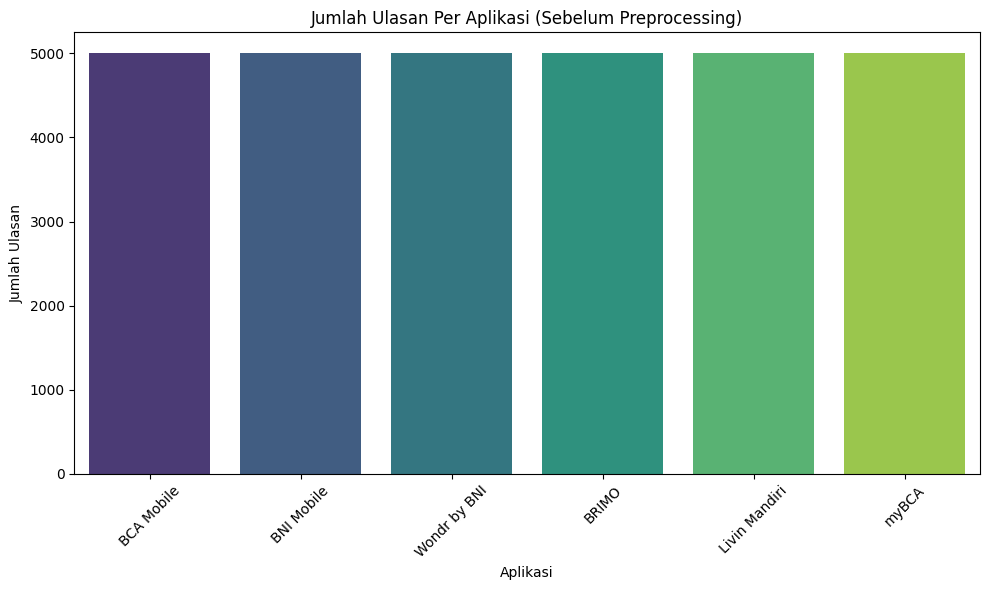

In [ ]:
# List of files
files = {
    "BCA Mobile": "ulasan_bca.csv",
    "BNI Mobile": "ulasan_bnimobile.csv",
    "Wondr by BNI": "ulasan_bniwondr.csv",
    "BRIMO": "ulasan_brimo.csv",
    "Livin Mandiri": "ulasan_livin.csv",
    "myBCA": "ulasan_mybca.csv"
}

# Load datasets
dfs = {}
for name, path in files.items():
    try:
        dfs[name] = pd.read_csv(path)
        dfs[name]['App'] = name
    except Exception as e:
        print(f"Error loading {name}: {e}")

# 1. Visualization of Review Counts (Raw Data)
plt.figure(figsize=(10, 6))
counts = {name: len(df) for name, df in dfs.items()}
sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette="viridis")
plt.title("Jumlah Ulasan Per Aplikasi (Sebelum Preprocessing)")
plt.ylabel("Jumlah Ulasan")
plt.xlabel("Aplikasi")
plt.xticks(rotation=45)
plt.tight_layout()

# 2. Findings before preprocessing (Quick inspection)
print("--- Temuan Awal Data (Head & Info) ---")
for name, df in dfs.items():
    print(f"\nAPP: {name}")
    print(f"Columns: {df.columns.tolist()}")
    print(f"Total Rows: {len(df)}")
    print("Sample Content:")
    print(df['content'].head().values)

    # Check for duplicates
    dupes = df.duplicated(subset=['content', 'userName']).sum()
    print(f"Duplicated Reviews: {dupes}")

    # Check for nulls in content
    nulls = df['content'].isnull().sum()
    print(f"Null Content: {nulls}")

EDA

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              30000 non-null  object
 1   userName              30000 non-null  object
 2   userImage             30000 non-null  object
 3   content               30000 non-null  object
 4   score                 30000 non-null  int64 
 5   thumbsUpCount         30000 non-null  int64 
 6   reviewCreatedVersion  24214 non-null  object
 7   at                    30000 non-null  object
 8   replyContent          24650 non-null  object
 9   repliedAt             24650 non-null  object
 10  appVersion            24214 non-null  object
 11  app_name              30000 non-null  object
dtypes: int64(2), object(10)
memory usage: 2.7+ MB
None
                               reviewId         userName  \
0  ddd9ebae-0aec-4977-ac95-9f726d87a0b8  Pengguna Google   
1  98e16d79-30d

/tmp/ipython-input-1635679364.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_all, x='app_name', y='review_len', palette='viridis')


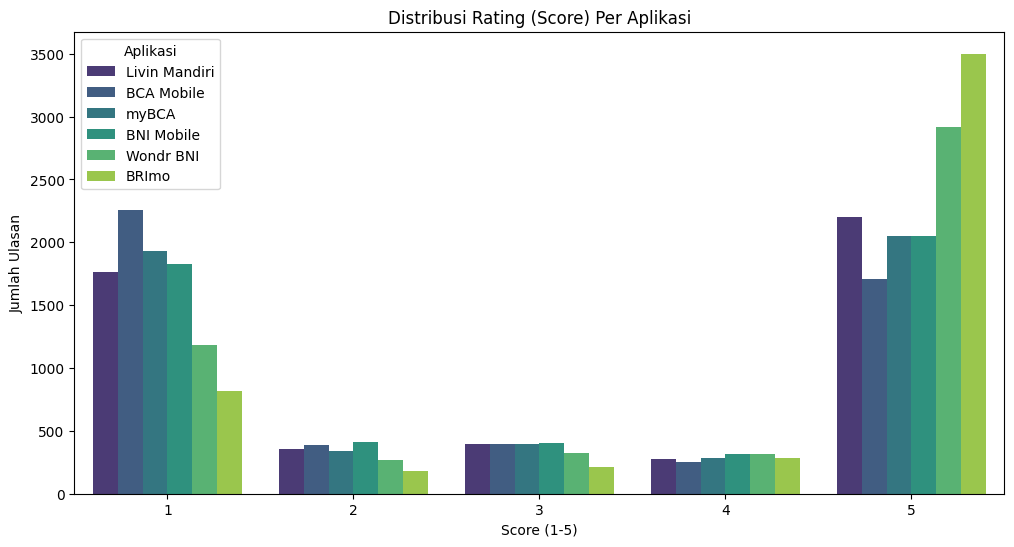

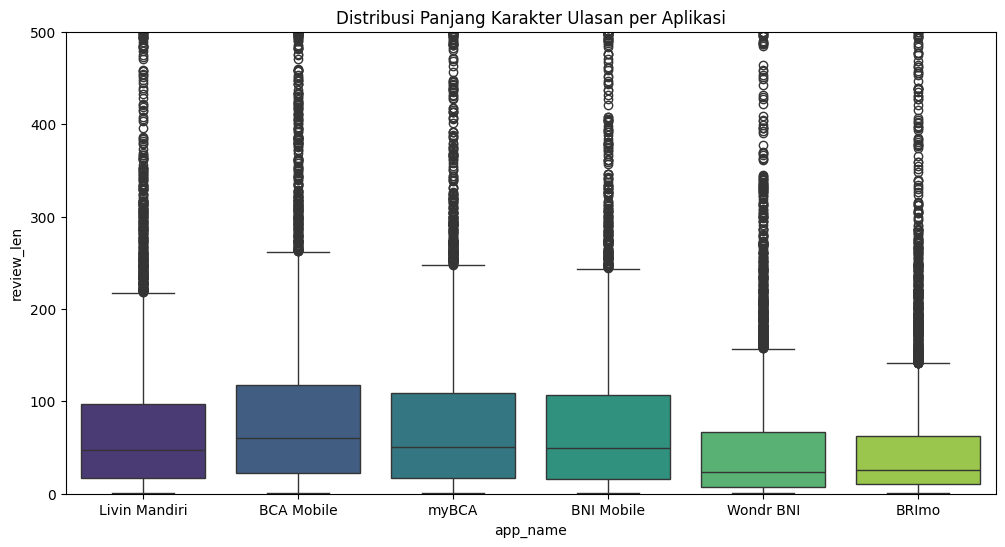

In [ ]:
# Load the datasets
files = {
    'Livin Mandiri': 'ulasan_livin.csv',
    'BCA Mobile': 'ulasan_bca.csv',
    'myBCA': 'ulasan_mybca.csv',
    'BNI Mobile': 'ulasan_bnimobile.csv',
    'Wondr BNI': 'ulasan_bniwondr.csv',
    'BRImo': 'ulasan_brimo.csv'
}

dfs = []
for app_name, file_path in files.items():
    try:
        df = pd.read_csv(file_path)
        df['app_name'] = app_name
        dfs.append(df)
    except Exception as e:
        print(f"Error loading {app_name}: {e}")

# Combine into one dataframe
if dfs:
    df_all = pd.concat(dfs, ignore_index=True)

    # Display basic info
    print(df_all.info())
    print(df_all.head())

    # --- EDA Step 2 ---
    # 1. Distribution of Scores
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df_all, x='score', hue='app_name', palette='viridis')
    plt.title('Distribusi Rating (Score) Per Aplikasi')
    plt.xlabel('Score (1-5)')
    plt.ylabel('Jumlah Ulasan')
    plt.legend(title='Aplikasi')
    plt.savefig('score_distribution.png')

    # 2. Review Length Analysis
    df_all['content'] = df_all['content'].astype(str)
    df_all['review_len'] = df_all['content'].apply(len)

    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df_all, x='app_name', y='review_len', palette='viridis')
    plt.title('Distribusi Panjang Karakter Ulasan per Aplikasi')
    plt.ylim(0, 500)
else:
    print("No data loaded.")

In [ ]:
import pandas as pd
import re

# --- 1. Load & Deduplicate Data ---
files = {
    "Livin Mandiri": "ulasan_livin.csv",
    "BCA Mobile": "ulasan_bca.csv",
    "myBCA": "ulasan_mybca.csv",
    "BNI Mobile": "ulasan_bnimobile.csv",
    "Wondr by BNI": "ulasan_bniwondr.csv",
    "BRIMO": "ulasan_brimo.csv"
}

dfs = {}
for name, path in files.items():
    try:
        df = pd.read_csv(path)
        df = df.drop_duplicates(subset=['content', 'userName'], keep='first')
        df['App'] = name
        dfs[name] = df
    except Exception as e:
        print(f"Error loading {name}: {e}")

# --- 2. Preprocessing Setup ---
stopwords_id = set([
    "yang", "dan", "di", "ke", "dari", "ini", "itu", "untuk", "pada", "adalah",
    "sebagai", "dengan", "juga", "karena", "tapi", "tetapi", "namun", "akan",
    "bisa", "ada", "tidak", "sudah", "saya", "kami", "kita", "kamu", "dia",
    "mereka", "anda", "aku", "lagi", "mau", "masih", "apa", "kenapa", "gimana",
    "saja", "kalau", "kalo", "biar", "kok", "mah", "dong", "sih", "nya",
    "bgt", "gak", "gk", "ga", "tp", "yg", "dgn", "sdh", "aja", "sy", "ma",
    "klo", "udh", "udah", "blm", "belum", "bkn", "bukan", "dr", "kl", "jd",
    "jdi", "kpn", "kapan", "krn", "msh", "msih", "sm", "sama", "utk", "untk",
    "dg", "dengn", "tuh", "deh", "kan", "lah", "pun", "kah",
    "bank", "aplikasi", "mobile", "banking"
])

# Merge Slang Dict with User's App Name Removal
slang_dict = {
    "gk": "tidak", "ga": "tidak", "gak": "tidak", "nggak": "tidak",
    "sy": "saya", "aq": "aku", "ak": "aku", "kamu": "anda",
    "bgt": "banget", "bgus": "bagus", "baguus": "bagus",
    "blm": "belum", "tdk": "tidak", "jgn": "jangan",
    "buka": "buka", "bs": "bisa", "bisaa": "bisa",
    "gabisa": "tidak bisa", "gabis": "tidak bisa",
    "eror": "error", "erorr": "error", "errorr": "error",
    "lola": "lambat", "lemot": "lambat", "lelet": "lambat",
    "mntap": "mantap", "mantul": "mantap", "sip": "mantap",
    "ok": "oke", "oke": "baik", "tq": "terima kasih",
    "thanks": "terima kasih", "makasih": "terima kasih",
    "thx": "terima kasih", "trimakasih": "terima kasih",
    "trf": "transfer", "tf": "transfer", "trs": "terus",
    "karna": "karena", "krn": "karena", "mulu": "terus",
    # App names removed as per user suggestion
    "brimo": "", "livin": "", "bca": "", "bni": "", "wondr": "", "mybca": ""
}

positive_words = set([
    "bagus", "baik", "mantap", "keren", "mudah", "cepat", "lancar",
    "puas", "suka", "oke", "aman", "membantu", "terbaik", "top", "jos",
    "gampang", "praktis", "memuaskan", "senang", "cinta", "hebat"
])
negative_words = set([
    "jelek", "buruk", "lambat", "susah", "ribet", "kecewa", "parah",
    "gagal", "error", "gangguan", "lelet", "lemot", "sampah", "kapok",
    "sulit", "rugi", "takut", "hilang", "benci", "kesal", "emosi",
    "bodoh", "rusak", "payah", "hancur", "berat", "lag", "bug"
])

def clean_text(text):
    if not isinstance(text, str): return ""
    text = text.lower()

    # 1. Normalize slang & Remove App Names
    words = text.split()
    words = [slang_dict.get(w, w) for w in words]
    text = " ".join(words)

    # 2. Regex Cleaning
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    text = re.sub(r'[^\x00-\x7F]+', ' ', text) 
    text = re.sub(r'\d+', '', text) 
    text = re.sub(r'[^\w\s]', ' ', text) 

    # 3. Filtering & Stemming (Simple Suffix)
    words = text.split()
    cleaned_words = []
    for w in words:
        if w.endswith('lah') and len(w) > 3: w = w[:-3]
        elif w.endswith('kah') and len(w) > 3: w = w[:-3]
        elif w.endswith('tah') and len(w) > 3: w = w[:-3]
        elif w.endswith('pun') and len(w) > 3: w = w[:-3]
        elif w.endswith('nya') and len(w) > 3: w = w[:-3]
        elif w.endswith('ku') and len(w) > 3: w = w[:-2]
        elif w.endswith('mu') and len(w) > 3: w = w[:-2]

        if len(w) <= 3: continue
        if w in stopwords_id: continue
        cleaned_words.append(w)

    return " ".join(cleaned_words)

# Apply Cleaning
processed_dfs = {}
for name, df in dfs.items():
    df = df.copy()
    df['cleaned_content'] = df['content'].apply(clean_text)
    df = df[df['cleaned_content'].str.strip() != ""]
    processed_dfs[name] = df

# --- 3. Labeling ---
def get_lexicon_label(text):
    words = text.split()
    score = 0
    for w in words:
        if w in positive_words: score += 1
        elif w in negative_words: score -= 1
    if score > 0: return "Positif"
    elif score < 0: return "Negatif"
    else: return "Netral"

def get_score_label(score):
    if score <= 2: return "Negatif"
    elif score == 3: return "Netral"
    else: return "Positif"

for name, df in processed_dfs.items():
    df['lexicon_label'] = df['cleaned_content'].apply(get_lexicon_label)
    df['score_label'] = df['score'].apply(get_score_label)

# --- PRINTING SAMPLES ---
print("==================================================")
print("      CONTOH DATA & HASIL PREPROCESSING          ")
print("==================================================")

for name, df in processed_dfs.items():
    print(f"\n>>> APLIKASI: {name}")
    print(f"    Total Data Bersih: {len(df)}")
    print("-" * 80)
    cols = ['content', 'cleaned_content', 'score_label', 'lexicon_label']
    print(df[cols].head(3).to_string(index=False))
    print("-" * 80)

      CONTOH DATA & HASIL PREPROCESSING          

>>> APLIKASI: Livin Mandiri
    Total Data Bersih: 4244
--------------------------------------------------------------------------------
                                                                                                                                                                                        content                                                                                                                                        cleaned_content score_label lexicon_label
                                                                                                                                                                                   eror muluuuu                                                                                                                                             error mulu     Negatif       Negatif
livi terlalu banyak maintence, setiap hari sekitar jam 23.00 sama jam 2 ma

In [ ]:
import pandas as pd
import re
from IPython.display import display

# --- 1. Load & Deduplicate Data ---
files = {
    "Livin Mandiri": "ulasan_livin.csv",
    "BCA Mobile": "ulasan_bca.csv",
    "myBCA": "ulasan_mybca.csv",
    "BNI Mobile": "ulasan_bnimobile.csv",
    "wondr by BNI": "ulasan_bniwondr.csv",
    "BRIMO": "ulasan_brimo.csv"
}

dfs = {}
for name, path in files.items():
    try:
        df = pd.read_csv(path)
        df = df.drop_duplicates(subset=['content', 'userName'], keep='first')
        df['App'] = name
        dfs[name] = df
    except Exception as e:
        print(f"Error loading {name}: {e}")

# --- 2. Preprocessing Setup ---
stopwords_id = set([
    "yang", "dan", "di", "ke", "dari", "ini", "itu", "untuk", "pada", "adalah",
    "sebagai", "dengan", "juga", "karena", "tapi", "tetapi", "namun", "akan",
    "bisa", "ada", "tidak", "sudah", "saya", "kami", "kita", "kamu", "dia",
    "mereka", "anda", "aku", "lagi", "mau", "masih", "apa", "kenapa", "gimana",
    "saja", "kalau", "kalo", "biar", "kok", "mah", "dong", "sih", "nya",
    "bgt", "gak", "gk", "ga", "tp", "yg", "dgn", "sdh", "aja", "sy", "ma",
    "klo", "udh", "udah", "blm", "belum", "bkn", "bukan", "dr", "kl", "jd",
    "jdi", "kpn", "kapan", "krn", "msh", "msih", "sm", "sama", "utk", "untk",
    "dg", "dengn", "tuh", "deh", "kan", "lah", "pun", "kah",
    "bank", "aplikasi", "mobile", "banking"
])

slang_dict = {
    "gk": "tidak", "ga": "tidak", "gak": "tidak", "nggak": "tidak",
    "sy": "saya", "aq": "aku", "ak": "aku", "kamu": "anda",
    "bgt": "banget", "bgus": "bagus", "baguus": "bagus",
    "blm": "belum", "tdk": "tidak", "jgn": "jangan",
    "buka": "buka", "bs": "bisa", "bisaa": "bisa",
    "gabisa": "tidak bisa", "gabis": "tidak bisa",
    "eror": "error", "erorr": "error", "errorr": "error",
    "lola": "lambat", "lemot": "lambat", "lelet": "lambat",
    "mntap": "mantap", "mantul": "mantap", "sip": "mantap",
    "ok": "oke", "oke": "baik", "tq": "terima kasih",
    "thanks": "terima kasih", "makasih": "terima kasih",
    "thx": "terima kasih", "trimakasih": "terima kasih",
    "trf": "transfer", "tf": "transfer", "trs": "terus",
    "karna": "karena", "krn": "karena", "mulu": "terus",
    "pdhl":"padahal", "prnah":"pernah", "prnh":"pernah", "lwak":"lawak",
    "ntar":"bentar", "bntr":"bentar", "ntr":"bentar", "gilak":"gila",
    "blnja":"belanja", "bangett":"banget",
    # Menghapus nama aplikasi (termasuk typo user "wonder")
    "brimo": "", "livin": "", "bca": "", "bni": "", "wondr": "", "wonder": "", "mybca": ""
}

positive_words = set([
    "bagus", "baik", "mantap", "keren", "mudah", "cepat", "lancar",
    "puas", "suka", "oke", "aman", "membantu", "terbaik", "top", "jos",
    "gampang", "praktis", "memuaskan", "senang", "cinta", "hebat"
])
negative_words = set([
    "jelek", "buruk", "lambat", "susah", "ribet", "kecewa", "parah",
    "gagal", "error", "gangguan", "lelet", "lemot", "sampah", "kapok",
    "sulit", "rugi", "takut", "hilang", "benci", "kesal", "emosi",
    "bodoh", "rusak", "payah", "hancur", "berat", "lag", "bug", "lawak"
])

def clean_text(text):
    if not isinstance(text, str): return ""
    text = text.lower()

    # 1. Normalize slang
    words = text.split()
    words = [slang_dict.get(w, w) for w in words]
    text = " ".join(words)

    # 2. Regex Cleaning
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', ' ', text)

    # 3. Filtering & Stemming
    words = text.split()
    cleaned_words = []
    for w in words:
        if w.endswith('lah') and len(w) > 3: w = w[:-3]
        elif w.endswith('kah') and len(w) > 3: w = w[:-3]
        elif w.endswith('tah') and len(w) > 3: w = w[:-3]
        elif w.endswith('pun') and len(w) > 3: w = w[:-3]
        elif w.endswith('nya') and len(w) > 3: w = w[:-3]
        elif w.endswith('ku') and len(w) > 3: w = w[:-2]
        elif w.endswith('mu') and len(w) > 3: w = w[:-2]
        elif w.endswith('ber') and len(w) > 3: w = w[:-3]

        if len(w) <= 3: continue
        if w in stopwords_id: continue
        cleaned_words.append(w)

    return " ".join(cleaned_words)

# Apply Cleaning
processed_dfs = {}
for name, df in dfs.items():
    df = df.copy()
    df['cleaned_content'] = df['content'].apply(clean_text)
    df = df[df['cleaned_content'].str.strip() != ""]
    processed_dfs[name] = df

# Apply Labels
def get_lexicon_label(text):
    words = text.split()
    score = 0
    for w in words:
        if w in positive_words: score += 1
        elif w in negative_words: score -= 1
    if score > 0: return "Positif"
    elif score < 0: return "Negatif"
    else: return "Netral"

def get_score_label(score):
    if score <= 2: return "Negatif"
    elif score == 3: return "Netral"
    else: return "Positif"

for name, df in processed_dfs.items():
    df['lexicon_label'] = df['cleaned_content'].apply(get_lexicon_label)
    df['score_label'] = df['score'].apply(get_score_label)

# --- DISPLAY OUTPUT ---
print("=== HASIL PREPROCESSING DATA ===")
cols = ['content', 'cleaned_content', 'score_label', 'lexicon_label']

for name, df in processed_dfs.items():
    print(f"\n APLIKASI: {name}")
    try:
        display(df[cols].head(3))
    except:
        print(df[cols].head(3).to_string(index=False))

=== HASIL PREPROCESSING DATA ===

 APLIKASI: Livin Mandiri


,content,cleaned_content,score_label,lexicon_label
0,eror muluuuu,error mulu,Negatif,Negatif
1,"livi terlalu banyak maintence, setiap hari sek...",livi terlalu banyak maintence setiap hari seki...,Netral,Netral
2,jam malam sering eror,malam sering error,Negatif,Negatif



 APLIKASI: BCA Mobile


,content,cleaned_content,score_label,lexicon_label
0,"Hadeh, udh isi 50k ko tiba"" saldo sisa 11k pdh...",hadeh tiba saldo sisa padahal pernah transaksi...,Negatif,Negatif
1,terbaik,terbaik,Positif,Positif
2,saldo saya habis dihek org gmna ini aplikasi n...,saldo habis dihek gmna aman atau,Negatif,Positif



 APLIKASI: myBCA


,content,cleaned_content,score_label,lexicon_label
0,sangat membantu,sangat membantu,Positif,Positif
1,"Buruk banget ih, jauh bagusan BCA Mobile walau...",buruk banget jauh bagusan walau jadul kata ter...,Negatif,Negatif
2,mantap,mantap,Positif,Positif



 APLIKASI: BNI Mobile


,content,cleaned_content,score_label,lexicon_label
0,kenapa saldo saya belum masuk kak padahal saya...,saldo masuk padahal kirim lewat kyodai sampai ...,Negatif,Negatif
1,"ini gimana ya kok ganguan terus, mau fi pakai ...",ganguan terus pakai transaksi tolong perbaiki,Netral,Netral
2,"susah , kadang buat malu, mau bayar buka mbang...",susah kadang buat malu bayar buka mbangking di...,Negatif,Negatif



 APLIKASI: wondr by BNI


,content,cleaned_content,score_label,lexicon_label
0,cepattt,cepat,Positif,Positif
1,jijik liat wondr ini. jam offline ntar beraturan,jijik liat offline bentar beraturan,Negatif,Netral
2,sengaja kasi Bintang 1 karena aplikasi ny jadi...,sengaja kasi bintang jadi buruk jelek transaks...,Negatif,Negatif



 APLIKASI: BRIMO


,content,cleaned_content,score_label,lexicon_label
0,kenapa aplikasi brimo nya kok gak muncul dilay...,muncul dilayar,Negatif,Netral
1,baik,baik,Positif,Positif
2,"mantap saya suka aplikasinya ,enak BSA bayar a...",mantap suka enak bayar disini,Positif,Positif


--- Final Summary Stats ---
score_label     Negatif    Netral   Positif
App                                        
BCA Mobile     0.596903  0.089274  0.313824
BNI Mobile     0.524668  0.090844  0.384488
BRIMO          0.261848  0.054541  0.683611
Livin Mandiri  0.494109  0.090009  0.415881
myBCA          0.525012  0.091789  0.383200
wondr by BNI   0.406026  0.084075  0.509900


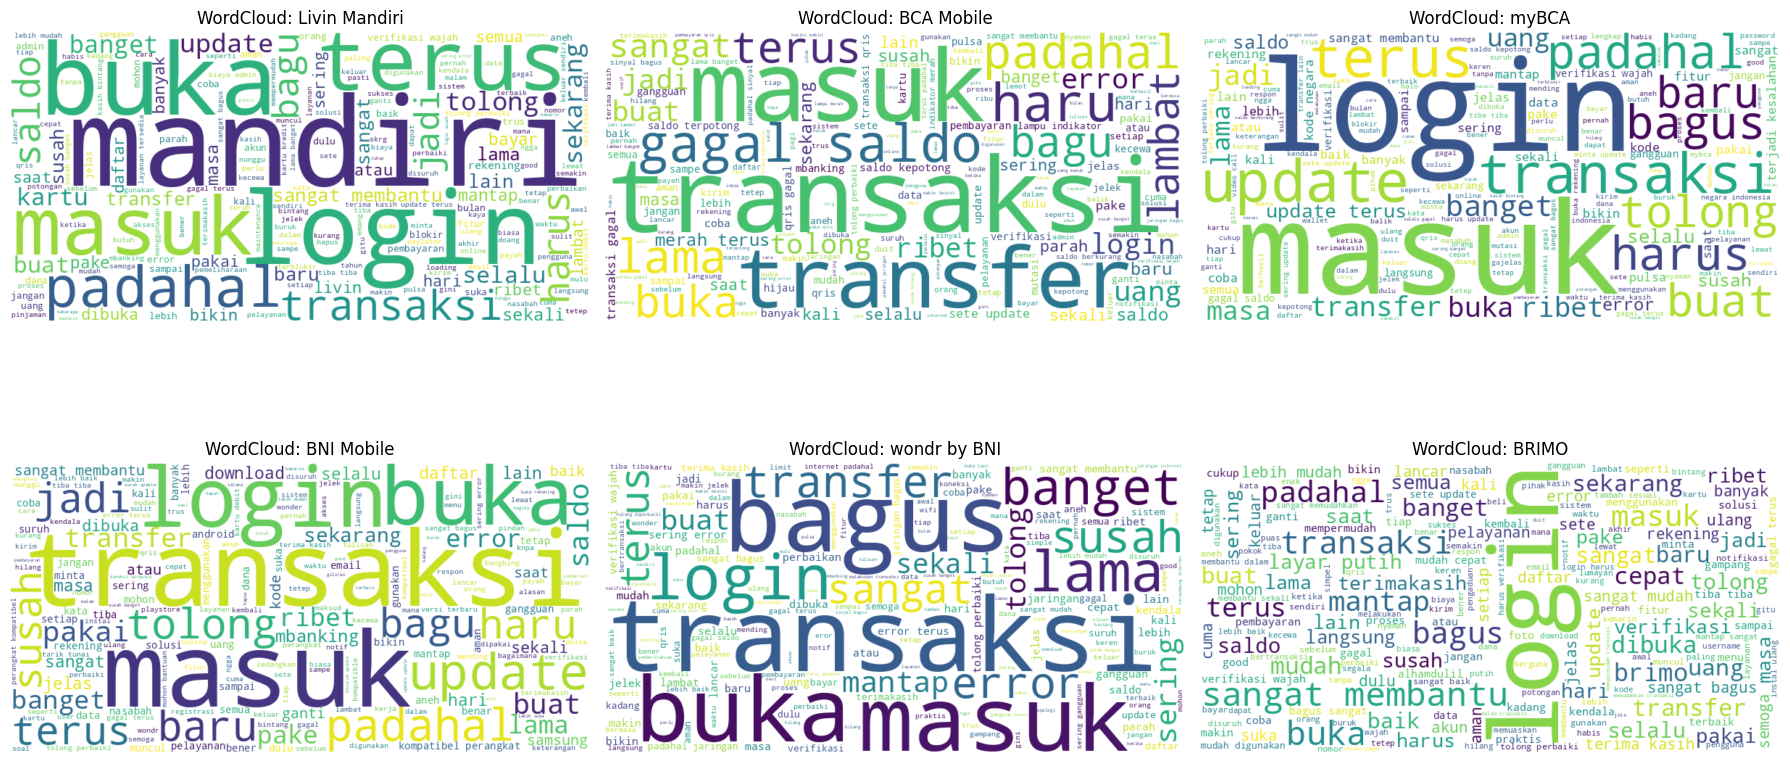

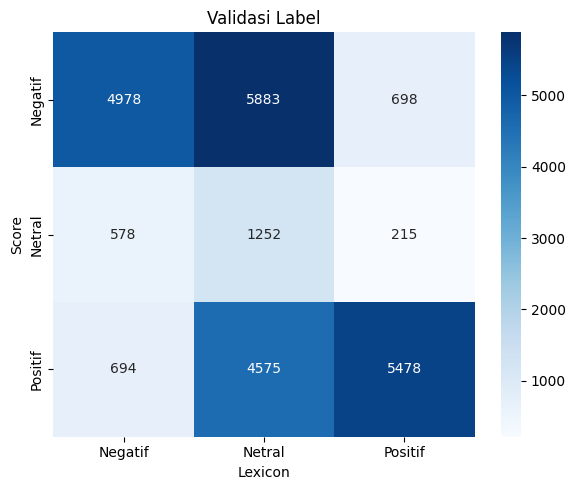

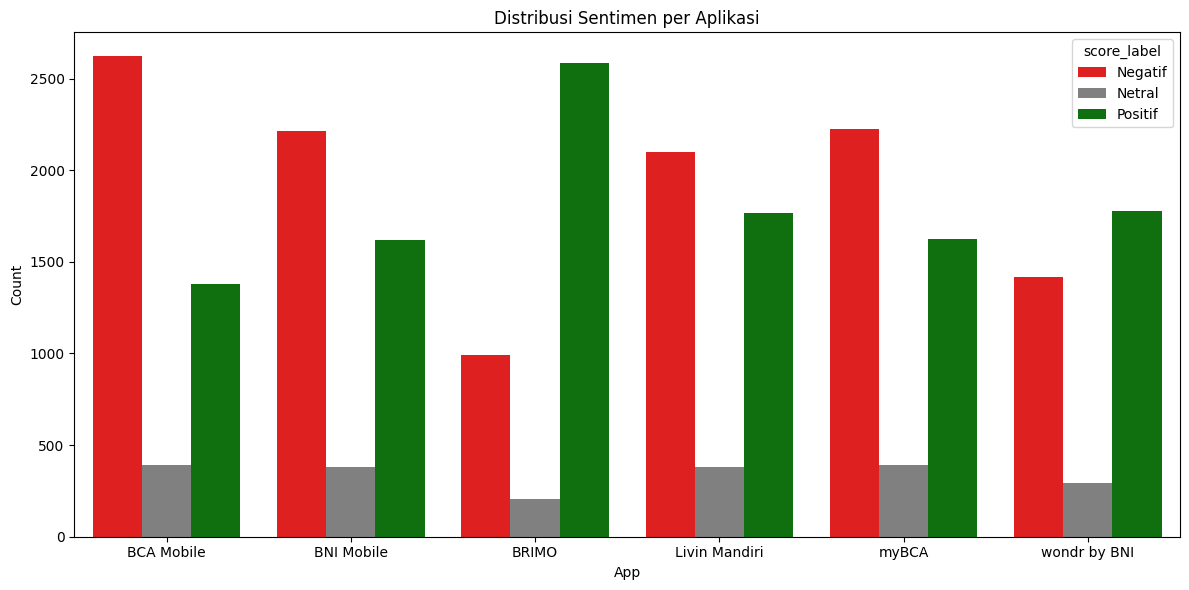

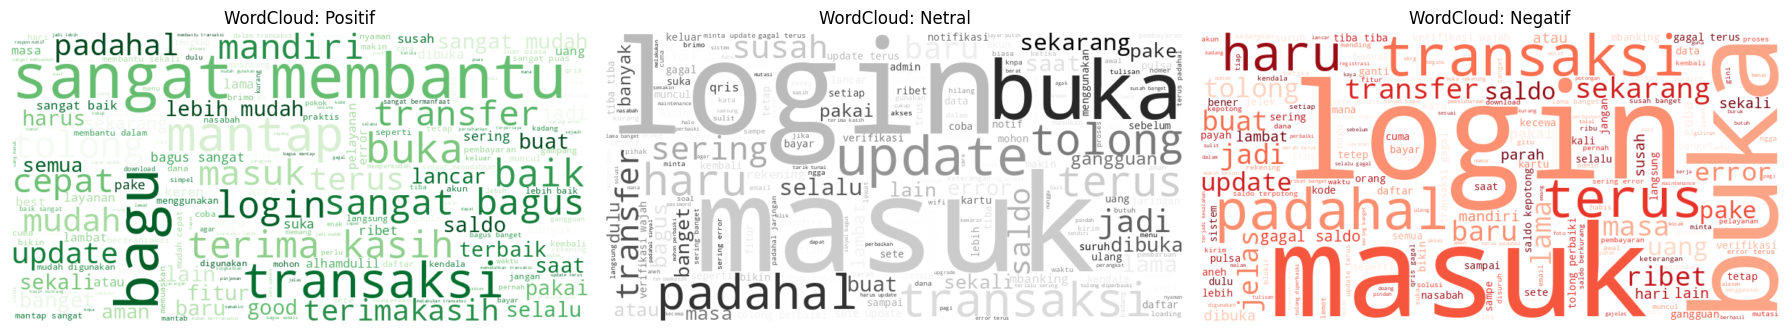

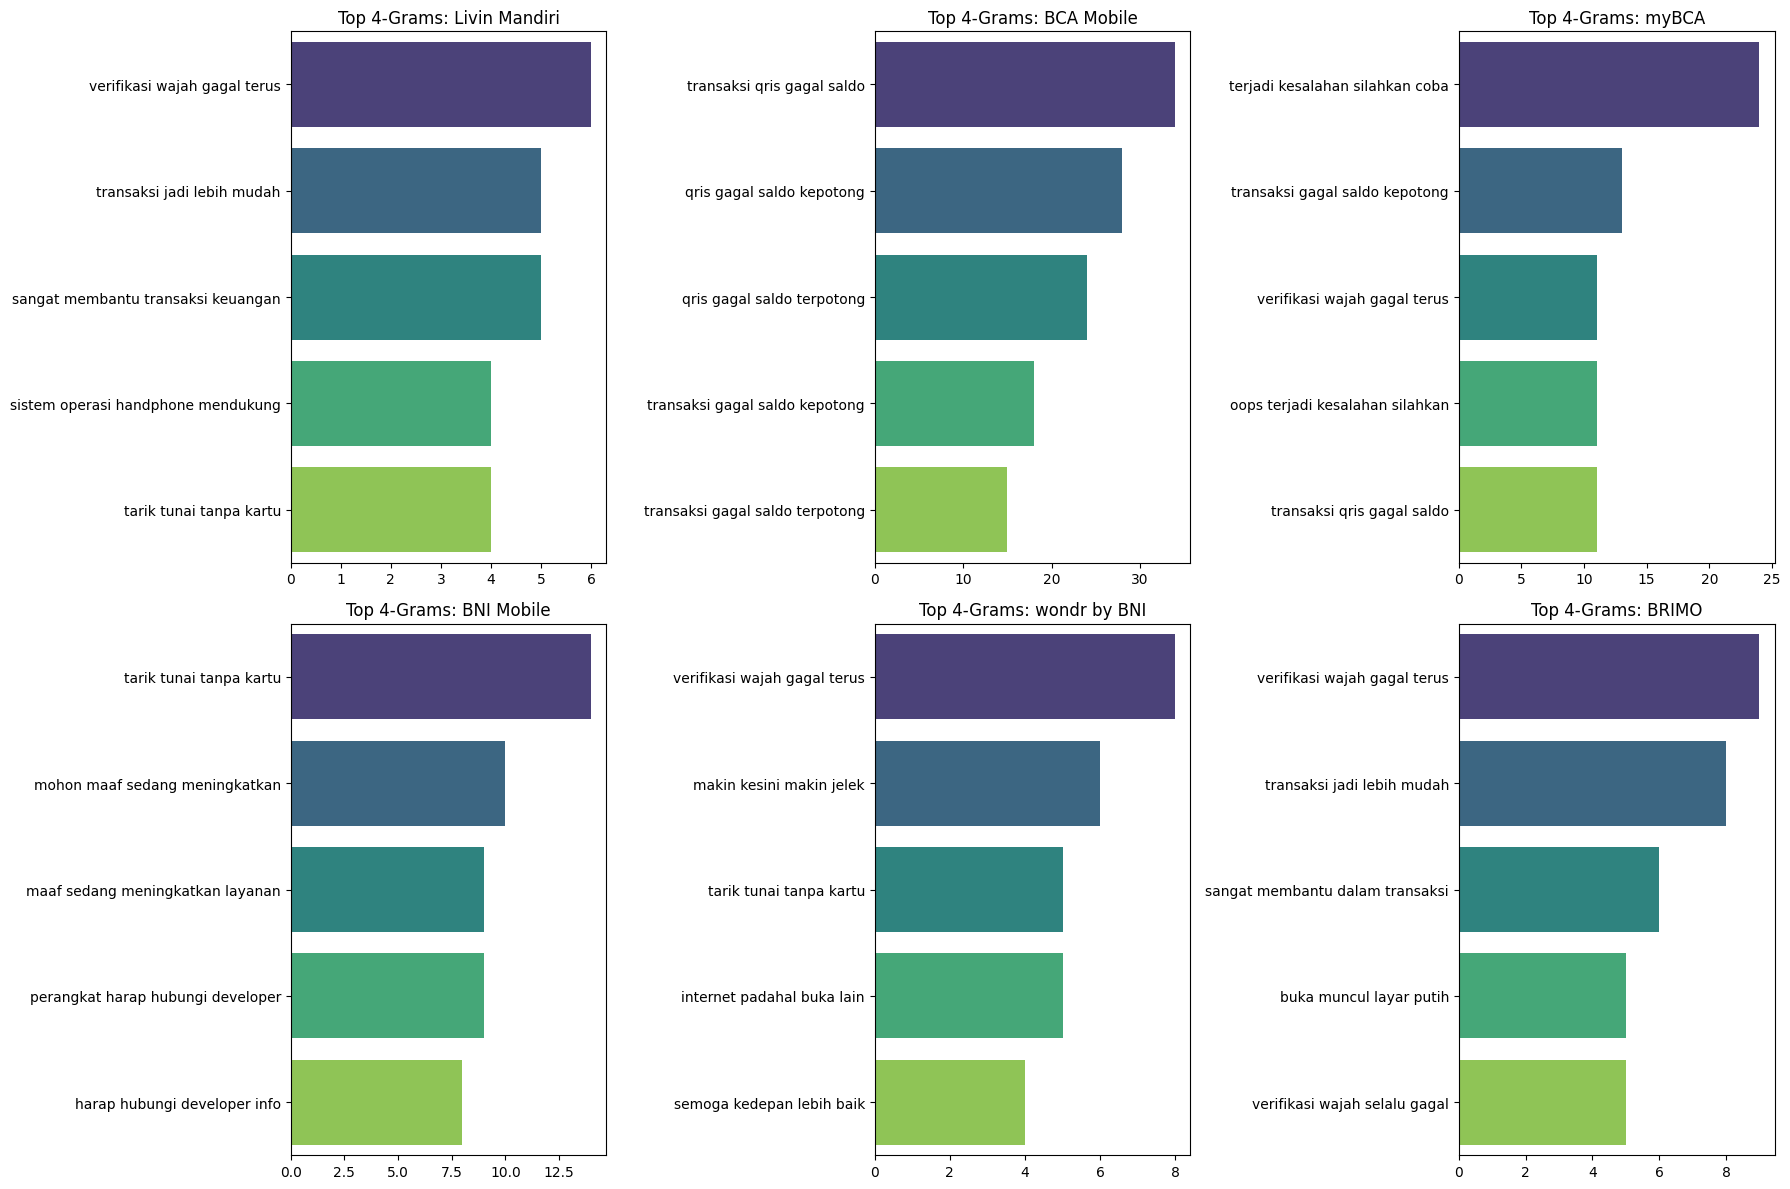

In [ ]:
# --- 4. Visualizations ---

# Combine all processed dataframes into a single dataframe for overall analysis
all_df = pd.concat(processed_dfs.values(), ignore_index=True)

# A. WordCloud per App
fig1, axes1 = plt.subplots(2, 3, figsize=(18, 10))
axes1 = axes1.flatten()
for i, (name, df) in enumerate(processed_dfs.items()):
    text = " ".join(df['cleaned_content'].astype(str).tolist())
    if not text.strip(): text = "kosong"
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    axes1[i].imshow(wc, interpolation='bilinear')
    axes1[i].set_title(f"WordCloud: {name}")
    axes1[i].axis('off')
plt.tight_layout()
plt.savefig("step4_wordclouds_final.png")

# B. Validation Matrix
cm = confusion_matrix(all_df['score_label'], all_df['lexicon_label'], labels=["Negatif", "Netral", "Positif"])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negatif", "Netral", "Positif"], yticklabels=["Negatif", "Netral", "Positif"])
plt.title("Validasi Label")
plt.ylabel("Score")
plt.xlabel("Lexicon")
plt.tight_layout()

# C. Sentiment Distribution
sentiment_counts = all_df.groupby(['App', 'score_label']).size().reset_index(name='Count')
plt.figure(figsize=(12, 6))
sns.barplot(data=sentiment_counts, x='App', y='Count', hue='score_label', palette={"Positif": "green", "Netral": "gray", "Negatif": "red"})
plt.title("Distribusi Sentimen per Aplikasi")
plt.tight_layout()

# D. WordCloud per Sentiment
fig4, axes4 = plt.subplots(1, 3, figsize=(18, 6))
sentiments = ["Positif", "Netral", "Negatif"]
colors = ["Greens", "Greys", "Reds"]
for i, sent in enumerate(sentiments):
    text = " ".join(all_df[all_df['score_label'] == sent]['cleaned_content'].astype(str).tolist())
    if not text.strip(): text = "kosong"
    wc = WordCloud(width=800, height=400, background_color='white', colormap=colors[i]).generate(text)
    axes4[i].imshow(wc, interpolation='bilinear')
    axes4[i].set_title(f"WordCloud: {sent}")
    axes4[i].axis('off')
plt.tight_layout()

# E. N-Grams (Fixed Warning)
def get_top_ngrams(corpus, n=4, k=5):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:k]

fig5, axes5 = plt.subplots(2, 3, figsize=(18, 12))
axes5 = axes5.flatten()
for i, (name, df) in enumerate(processed_dfs.items()):
    try:
        top_ngrams = get_top_ngrams(df['cleaned_content'].astype(str), n=4, k=5)
        if top_ngrams:
            x, y = zip(*top_ngrams)
            sns.barplot(x=list(y), y=list(x), ax=axes5[i], orient='h', palette='viridis', hue=list(x))
            if axes5[i].legend_:
                axes5[i].legend_.remove()
        axes5[i].set_title(f"Top 4-Grams: {name}")
    except ValueError:
        axes5[i].text(0.5, 0.5, "Not enough data", ha='center')
plt.tight_layout()
plt.savefig("step7_ngrams_final.png")

# Summary
print("--- Final Summary Stats ---")
print(all_df.groupby('App')['score_label'].value_counts(normalize=True).unstack())